In [25]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 14 23:26:53 2022

@author: ethan
"""
import json
import math
from scipy.io import wavfile
import os
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import numpy as np
from scipy import signal
import pickle


In [38]:
# define functions to load in data
def loadJson(dir):
    data_path = dir + "\\examples.json"
    with open(data_path,"r") as fp:
        data_json = json.load(fp)
    return data_json

def get_spectrogram(waveform):
    frame_length = 512
    frame_step = 256
    mel_spectrogram = tfio.audio.melscale(tfio.audio.spectrogram(input=tf.cast(waveform, tf.float32), nfft=frame_length, window=frame_length, stride=frame_step), rate=16000, mels=128, fmin=0, fmax=8000)
    return mel_spectrogram

def loadDataset(datajson, path, ds_range):
    ds_size = ds_range[1]-ds_range[0]
    instrument_ids = np.zeros(ds_size)
    pitch_ids = np.zeros(ds_size)
    sxx_log = np.zeros((ds_size,250,128))
    idxrange = range(ds_range[0],ds_range[1])
    keylist = list(datajson.keys())
    for i,j in enumerate(idxrange):
        file = keylist[j]
        sxx_log[i][:][:] = tfio.audio.dbscale(tf.cast(get_spectrogram(wavfile.read(path + "\\audio\\" + file + ".wav")[1]),dtype=tf.float32), top_db=80)
        instrument_ids[i] = datajson[file]["instrument_family"]
        pitch_ids[i] = datajson[file]["pitch"]
    return sxx_log, instrument_ids, pitch_ids
    

In [22]:
# Open json with all metadata
train_dir = os.getcwd() + "\\nsynth-train"
valid_dir = os.getcwd() + "\\nsynth-valid"
test_dir = os.getcwd() + "\\nsynth-test"

train_json = loadJson(train_dir)
valid_json = loadJson(valid_dir)
test_json = loadJson(test_dir)

# human readable labels for data    
instrument_names = ["bass","brass","flute","guitar","keyboard","mallet","organ","reed","string","synth_lead","vocal"]

In [39]:
# load in data sets
ds_size_train = 5000
ds_range_train = [0,ds_size_train]
num_train_sets = math.ceil(len(train_json)/ds_size_train)
ds_size_val = len(valid_json)
ds_range_val = [0,ds_size_val]
ds_size_test = len(test_json)
ds_range_test = [0,ds_size_test]

#train_set, train_inst_id, _ = loadDataset(train_json,train_dir,ds_range_train)
valid_set, valid_inst_id, _ = loadDataset(valid_json,valid_dir,ds_range_val)
test_set, test_inst_id, _ = loadDataset(test_json,test_dir,ds_range_test)


In [40]:
# save the spectrogram sets so we don't have to generate again if we want
#with open(valid_dir+"\\valid_set","wb") as fp:
#    pickle.dump((valid_set,valid_inst_id),fp)
#with open(test_dir+"\\test_set","wb") as fp:
#    pickle.dump((test_set,test_inst_id),fp)

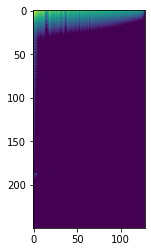

In [41]:
# look at a spectrogram
plt.figure()
plt.imshow(test_set[3][:][:])
plt.show()


In [42]:
# get some parameters for model
num_classes = len(instrument_names)
img_height = tf.shape(test_set)[1]
img_width = tf.shape(test_set)[2]
max_val = tf.math.reduce_max(test_set)
#max_val = 150


In [43]:
# make model
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./max_val, input_shape=(img_height, img_width,1)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [44]:
# set hyperparameters
learning_rate = 0.125

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['accuracy']
model.compile(optimizer, loss_fn, metrics)


In [45]:
# Set the epochs
epochs = 15
print('\nFitting:')

# Train the model. Batch size of 32 by default
for chunk in range(0,num_train_sets):
    print('\nStarting training data chunk %d/%d' % (chunk+1,num_train_sets))
    if chunk != num_train_sets-1:
        range_train = range(chunk*ds_size_train,(chunk+1)*ds_size_train)
    else:
        range_train = range(chunk*ds_size_train,len(train_json)-1)
    train_set, train_inst_id, _ = loadDataset(train_json,train_dir,ds_range_train)
    
    history = model.fit(train_set,train_inst_id, epochs=epochs,validation_data=(valid_set,valid_inst_id))
    
    



Fitting:
Epoch 1/15
157/157 [==============================] - 107s 656ms/step - loss: 2.0701 - accuracy: 0.2578 - val_loss: 2.1073 - val_accuracy: 0.1418
Epoch 2/15
157/157 [==============================] - 79s 507ms/step - loss: 1.6797 - accuracy: 0.3828 - val_loss: 1.6483 - val_accuracy: 0.3745
Epoch 3/15
157/157 [==============================] - 80s 512ms/step - loss: 1.4187 - accuracy: 0.4912 - val_loss: 1.5087 - val_accuracy: 0.4844
Epoch 4/15
157/157 [==============================] - 81s 518ms/step - loss: 1.2056 - accuracy: 0.5668 - val_loss: 1.5175 - val_accuracy: 0.5006
Epoch 5/15
157/157 [==============================] - 82s 523ms/step - loss: 1.0526 - accuracy: 0.6186 - val_loss: 1.3374 - val_accuracy: 0.5387
Epoch 6/15
157/157 [==============================] - 86s 552ms/step - loss: 0.9057 - accuracy: 0.6844 - val_loss: 1.9340 - val_accuracy: 0.5287
Epoch 7/15
157/157 [==============================] - 87s 553ms/step - loss: 0.7717 - accuracy: 0.7294 - val_loss: 1.51

In [ ]:
predicitons = model.predict(test_set)


In [ ]:
predictions_hard_decision = tf.math.argmax(predicitons,axis=1)
conf_matrix = tf.math.confusion_matrix(test_inst_id, predictions_hard_decision)
conf_matrix